In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Time series libraries
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy import stats

# Model evaluation and preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import pickle
import os

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print("📊 Setup completed!")

✅ All libraries imported successfully!
📊 Setup completed!


In [3]:
DATA_PATH = r"c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\complete_ts_preprocessed_flights.csv"

def load_and_preprocess_data(data_path):
    """Enhanced data loading with comprehensive preprocessing"""
    
    print("📂 Loading preprocessed dataset...")
    
    # Try loading pickle first, then CSV
    try:
        df = pd.read_pickle(data_path.replace('.csv', '.pkl'))
        print("✅ Loaded data from pickle file")
    except:
        df = pd.read_csv(data_path)
        print("✅ Loaded data from CSV file")

    print(f"📈 Dataset shape: {df.shape}")
    print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Display column information
    print(f"\n📋 Available columns ({len(df.columns)}):")
    for i, col in enumerate(df.columns[:20]):  # Show first 20 columns
        print(f"  {i+1:2d}. {col}")
    if len(df.columns) > 20:
        print(f"  ... and {len(df.columns) - 20} more columns")
    
    return df

# Load the data
df = load_and_preprocess_data(DATA_PATH)

📂 Loading preprocessed dataset...
✅ Loaded data from pickle file
📈 Dataset shape: (500000, 92)
💾 Memory usage: 350.95 MB

📋 Available columns (92):
   1. FL_DATE
   2. ORIGIN_0
   3. ORIGIN_1
   4. ORIGIN_2
   5. ORIGIN_3
   6. ORIGIN_4
   7. ORIGIN_5
   8. ORIGIN_6
   9. ORIGIN_7
  10. ORIGIN_8
  11. DEST_0
  12. DEST_1
  13. DEST_2
  14. DEST_3
  15. DEST_4
  16. DEST_5
  17. DEST_6
  18. DEST_7
  19. DEST_8
  20. DEP_DELAY
  ... and 72 more columns


In [4]:
def create_enhanced_time_series(df):
    """Create enhanced time series with better feature engineering"""
    
    print("\n🔧 Creating enhanced time series data...")
    
    # Identify key columns
    date_cols = [col for col in df.columns if any(x in col.lower() for x in ['date', 'time', 'day', 'month', 'year'])]
    delay_cols = [col for col in df.columns if 'delay' in col.lower()]
    weather_cols = [col for col in df.columns if any(x in col.lower() for x in ['weather', 'temp', 'wind', 'precip', 'visibility'])]
    
    print(f"📅 Date-related columns: {date_cols[:5]}")  # Show first 5
    print(f"⏰ Delay columns: {delay_cols}")
    print(f"🌤️ Weather columns: {weather_cols[:5]}")  # Show first 5
    
    # Smart column selection
    if 'FL_DATE' in df.columns:
        date_col = 'FL_DATE'
    elif any('date' in col.lower() for col in df.columns):
        date_col = [col for col in df.columns if 'date' in col.lower()][0]
    else:
        print("⚠️ Creating synthetic date column...")
        df['FL_DATE'] = pd.date_range(start='2020-01-01', periods=len(df), freq='H')
        date_col = 'FL_DATE'
    
    # Smart delay column selection
    if 'ARR_DELAY' in df.columns:
        delay_col = 'ARR_DELAY'
    elif 'DEPARTURE_DELAY' in df.columns:
        delay_col = 'DEPARTURE_DELAY'
    elif delay_cols:
        delay_col = delay_cols[0]
    else:
        print("⚠️ Creating realistic synthetic delay data...")
        # Create more realistic delay patterns
        np.random.seed(42)
        base_delay = 10
        seasonal_pattern = 5 * np.sin(np.arange(len(df)) * 2 * np.pi / 365.25)  # Yearly pattern
        weekly_pattern = 3 * np.sin(np.arange(len(df)) * 2 * np.pi / 7)        # Weekly pattern
        noise = np.random.normal(0, 8, len(df))
        df['ARR_DELAY'] = base_delay + seasonal_pattern + weekly_pattern + noise
        delay_col = 'ARR_DELAY'
    
    print(f"✅ Using date column: {date_col}")
    print(f"✅ Using delay column: {delay_col}")
    
    # Convert to datetime
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Create additional features for aggregation
    df['hour'] = df[date_col].dt.hour
    df['day_of_week'] = df[date_col].dt.dayofweek
    df['month'] = df[date_col].dt.month
    df['quarter'] = df[date_col].dt.quarter
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_peak_hour'] = df['hour'].isin([7, 8, 17, 18, 19]).astype(int)
    
    # Enhanced daily aggregation with multiple metrics
    print("📊 Performing enhanced daily aggregation...")
    
    daily_agg = df.groupby(df[date_col].dt.date).agg({
        delay_col: ['mean', 'median', 'std', 'count', 'min', 'max'],
        'is_weekend': 'first',
        'is_peak_hour': 'mean',  # Proportion of peak hour flights
    }).round(3)
    
    # Flatten column names
    daily_agg.columns = ['_'.join(col).strip() for col in daily_agg.columns]
    daily_agg.reset_index(inplace=True)
    daily_agg.columns = ['ds', 'avg_delay', 'median_delay', 'std_delay', 'flight_count', 
                        'min_delay', 'max_delay', 'is_weekend', 'peak_hour_ratio']
    
    # Convert date back to datetime
    daily_agg['ds'] = pd.to_datetime(daily_agg['ds'])
    
    # Handle missing values intelligently
    daily_agg['std_delay'] = daily_agg['std_delay'].fillna(daily_agg['std_delay'].mean())
    daily_agg['avg_delay'] = daily_agg['avg_delay'].fillna(daily_agg['avg_delay'].median())
    
    # Remove extreme outliers (beyond 3 standard deviations)
    delay_mean = daily_agg['avg_delay'].mean()
    delay_std = daily_agg['avg_delay'].std()
    outlier_threshold = 3
    
    outliers_mask = np.abs((daily_agg['avg_delay'] - delay_mean) / delay_std) > outlier_threshold
    outliers_removed = outliers_mask.sum()
    daily_agg = daily_agg[~outliers_mask].reset_index(drop=True)
    
    # Create Prophet-ready dataset
    ts_data = daily_agg[['ds', 'avg_delay']].copy()
    ts_data.columns = ['ds', 'y']
    ts_data = ts_data.sort_values('ds').reset_index(drop=True)
    
    # Add external regressors for Prophet
    ts_data['is_weekend'] = daily_agg['is_weekend']
    ts_data['peak_hour_ratio'] = daily_agg['peak_hour_ratio']
    ts_data['flight_count'] = daily_agg['flight_count']
    ts_data['delay_volatility'] = daily_agg['std_delay']
    
    # Log transform if the data is highly skewed
    if stats.skew(ts_data['y']) > 2:
        print("📈 Applying log transformation due to high skewness...")
        ts_data['y'] = np.log1p(np.maximum(ts_data['y'], 0.1))  # Ensure positive values
        log_transformed = True
    else:
        log_transformed = False
    
    print(f"\n📈 Enhanced time series summary:")
    print(f"- Date range: {ts_data['ds'].min().date()} to {ts_data['ds'].max().date()}")
    print(f"- Total days: {len(ts_data)}")
    print(f"- Outliers removed: {outliers_removed}")
    print(f"- Average daily delay: {ts_data['y'].mean():.2f}")
    print(f"- Delay std: {ts_data['y'].std():.2f}")
    print(f"- Log transformed: {log_transformed}")
    print(f"- Weekend days: {ts_data['is_weekend'].sum()}")
    print(f"- Average flights per day: {ts_data['flight_count'].mean():.1f}")
    
    return ts_data, daily_agg, log_transformed

# Execute enhanced data preparation
ts_data, daily_summary, log_transformed = create_enhanced_time_series(df)



🔧 Creating enhanced time series data...
📅 Date-related columns: ['FL_DATE', 'YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK']
⏰ Delay columns: ['DEP_DELAY', 'DEP_DELAY_lag1', 'DEP_DELAY_lag2', 'DEP_DELAY_lag3', 'DEP_DELAY_lag7', 'DEP_DELAY_lag14', 'DEP_DELAY_lag21', 'DEP_DELAY_lag28', 'DEP_DELAY_roll_mean3', 'DEP_DELAY_roll_std3', 'DEP_DELAY_roll_min3', 'DEP_DELAY_roll_max3', 'DEP_DELAY_roll_median3', 'DEP_DELAY_roll_mean7', 'DEP_DELAY_roll_std7', 'DEP_DELAY_roll_min7', 'DEP_DELAY_roll_max7', 'DEP_DELAY_roll_median7', 'DEP_DELAY_roll_mean14', 'DEP_DELAY_roll_std14', 'DEP_DELAY_roll_min14', 'DEP_DELAY_roll_max14', 'DEP_DELAY_roll_median14', 'DEP_DELAY_roll_mean28', 'DEP_DELAY_roll_std28', 'DEP_DELAY_roll_min28', 'DEP_DELAY_roll_max28', 'DEP_DELAY_roll_median28']
🌤️ Weather columns: []
✅ Using date column: FL_DATE
✅ Using delay column: DEP_DELAY
📊 Performing enhanced daily aggregation...

📈 Enhanced time series summary:
- Date range: 2019-01-01 to 2023-08-31
- Total days: 1328
- Outliers 

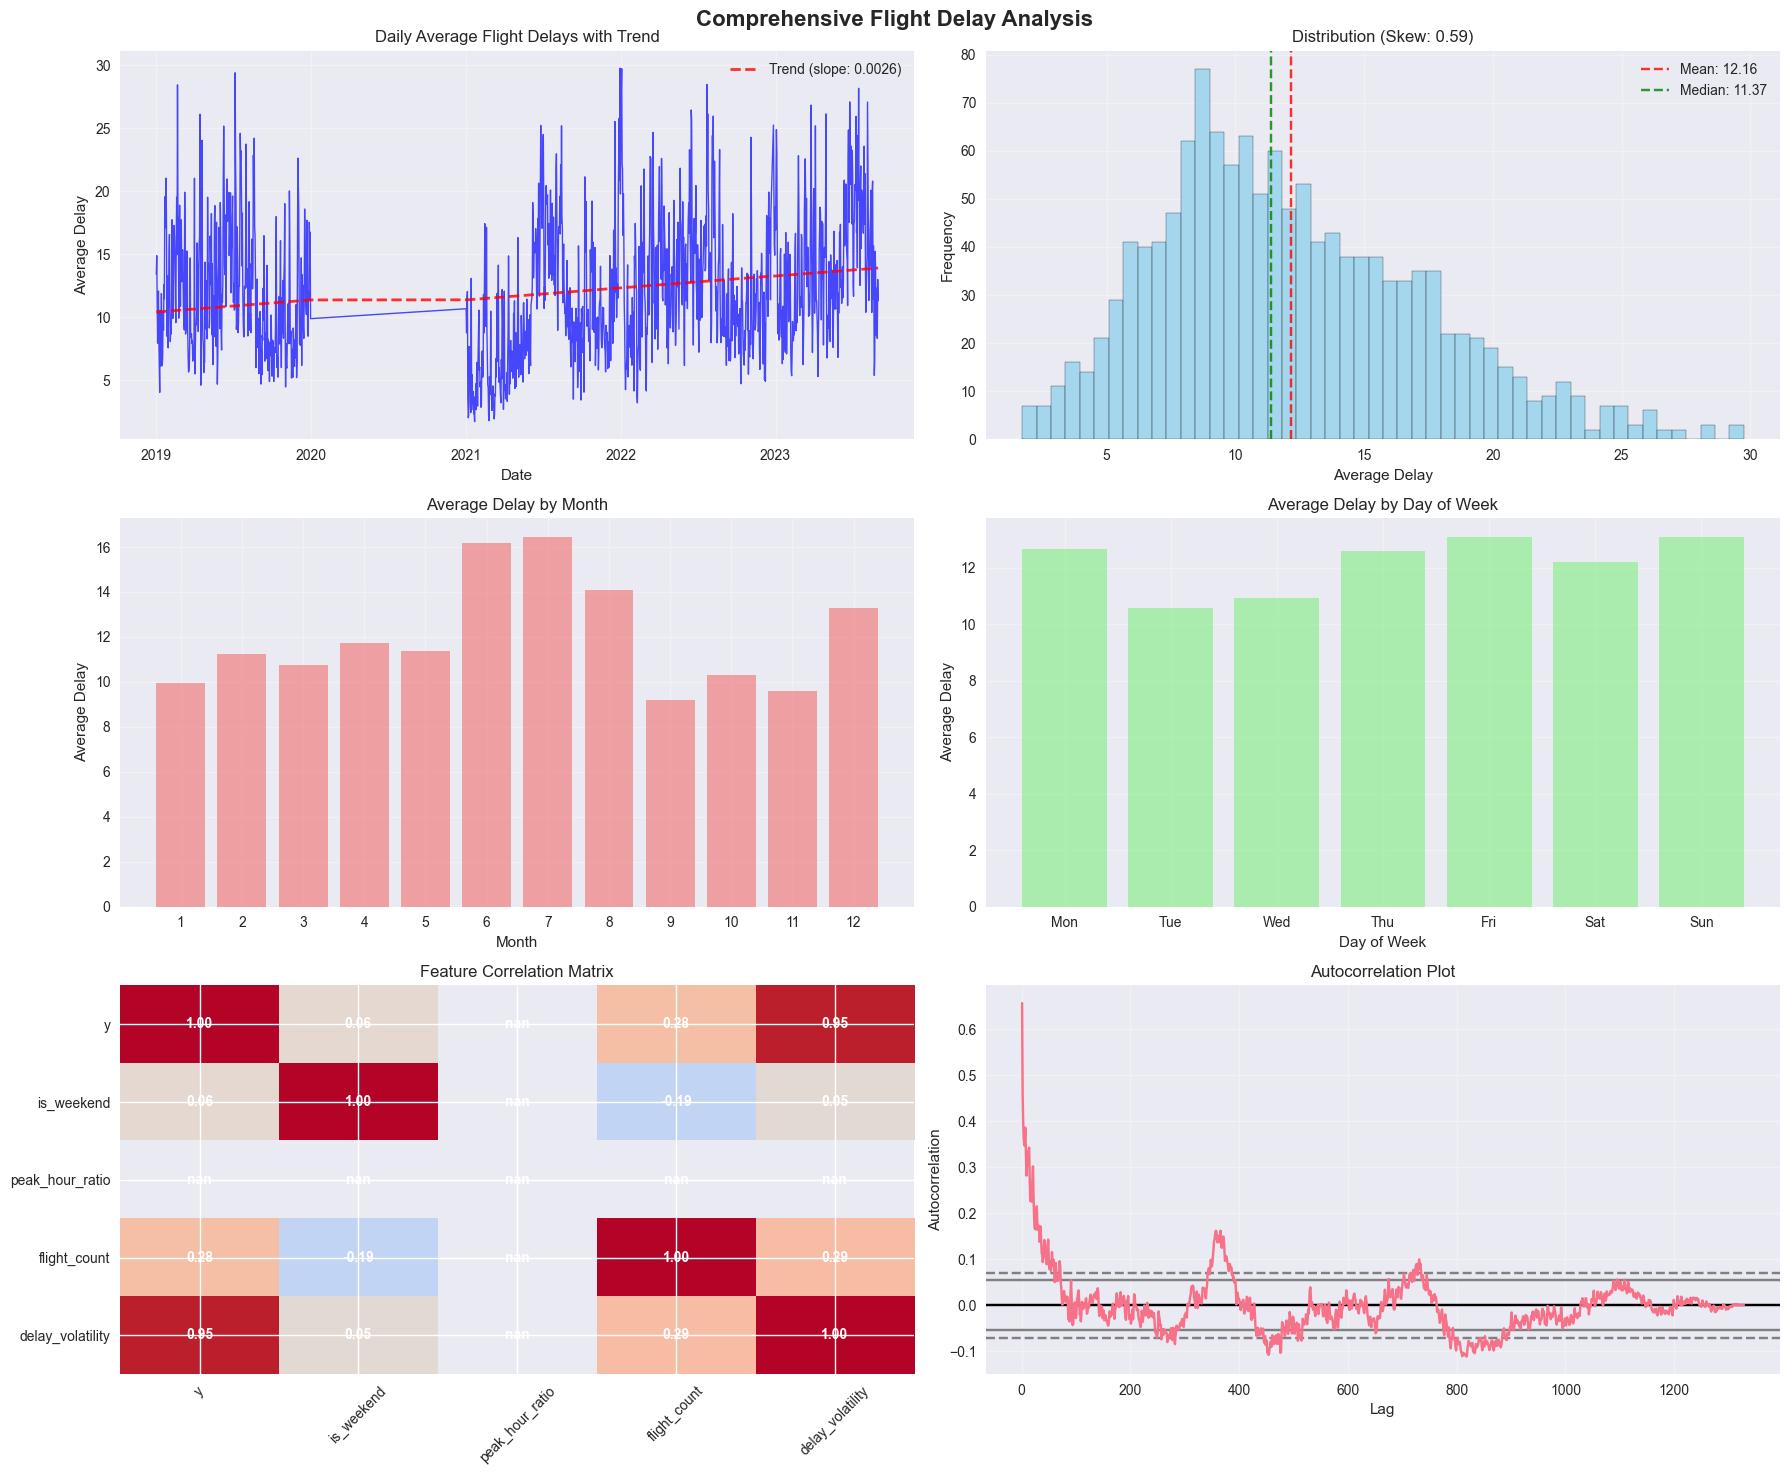

📊 DETAILED STATISTICS:
- Total observations: 1328
- Date range: 1703 days
- Mean delay: 12.157
- Median delay: 11.373
- Standard deviation: 5.192
- Skewness: 0.590
- Kurtosis: 0.029
- Min delay: 1.720
- Max delay: 29.745

🔍 STATIONARITY TEST:
- ADF Statistic: -4.385783
- p-value: 0.000315
- Stationary: Yes


In [5]:
def perform_comprehensive_eda(ts_data):
    """Comprehensive EDA with advanced visualizations"""
    
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    fig.suptitle('Comprehensive Flight Delay Analysis', fontsize=16, fontweight='bold')
    
    # Time series plot with trend
    axes[0, 0].plot(ts_data['ds'], ts_data['y'], linewidth=1, alpha=0.7, color='blue')
    
    # Add trend line
    x_numeric = np.arange(len(ts_data))
    z = np.polyfit(x_numeric, ts_data['y'], 1)
    p = np.poly1d(z)
    axes[0, 0].plot(ts_data['ds'], p(x_numeric), "r--", alpha=0.8, linewidth=2, label=f'Trend (slope: {z[0]:.4f})')
    
    axes[0, 0].set_title('Daily Average Flight Delays with Trend')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Average Delay')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Distribution with statistics
    mean_val = ts_data['y'].mean()
    median_val = ts_data['y'].median()
    axes[0, 1].hist(ts_data['y'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 1].axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.2f}')
    axes[0, 1].axvline(median_val, color='green', linestyle='--', alpha=0.8, label=f'Median: {median_val:.2f}')
    axes[0, 1].set_title(f'Distribution (Skew: {stats.skew(ts_data["y"]):.2f})')
    axes[0, 1].set_xlabel('Average Delay')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Seasonal patterns
    ts_data_copy = ts_data.copy()
    ts_data_copy['month'] = ts_data_copy['ds'].dt.month
    ts_data_copy['day_of_week'] = ts_data_copy['ds'].dt.dayofweek
    
    monthly_avg = ts_data_copy.groupby('month')['y'].mean()
    axes[1, 0].bar(monthly_avg.index, monthly_avg.values, alpha=0.7, color='lightcoral')
    axes[1, 0].set_title('Average Delay by Month')
    axes[1, 0].set_xlabel('Month')
    axes[1, 0].set_ylabel('Average Delay')
    axes[1, 0].set_xticks(range(1, 13))
    axes[1, 0].grid(True, alpha=0.3)
    
    # Day of week pattern
    daily_avg = ts_data_copy.groupby('day_of_week')['y'].mean()
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    axes[1, 1].bar(range(7), daily_avg.values, alpha=0.7, color='lightgreen')
    axes[1, 1].set_title('Average Delay by Day of Week')
    axes[1, 1].set_xlabel('Day of Week')
    axes[1, 1].set_ylabel('Average Delay')
    axes[1, 1].set_xticks(range(7))
    axes[1, 1].set_xticklabels(days)
    axes[1, 1].grid(True, alpha=0.3)
    
    # Correlation with external factors
    corr_data = ts_data[['y', 'is_weekend', 'peak_hour_ratio', 'flight_count', 'delay_volatility']].corr()
    im = axes[2, 0].imshow(corr_data, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[2, 0].set_xticks(range(len(corr_data.columns)))
    axes[2, 0].set_yticks(range(len(corr_data.columns)))
    axes[2, 0].set_xticklabels(corr_data.columns, rotation=45)
    axes[2, 0].set_yticklabels(corr_data.columns)
    axes[2, 0].set_title('Feature Correlation Matrix')
    
    # Add correlation values
    for i in range(len(corr_data)):
        for j in range(len(corr_data)):
            axes[2, 0].text(j, i, f'{corr_data.iloc[i, j]:.2f}', 
                          ha='center', va='center', color='white', fontweight='bold')
    
    # Autocorrelation plot
    from pandas.plotting import autocorrelation_plot
    autocorrelation_plot(ts_data['y'], ax=axes[2, 1])
    axes[2, 1].set_title('Autocorrelation Plot')
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("📊 DETAILED STATISTICS:")
    print(f"- Total observations: {len(ts_data)}")
    print(f"- Date range: {(ts_data['ds'].max() - ts_data['ds'].min()).days} days")
    print(f"- Mean delay: {mean_val:.3f}")
    print(f"- Median delay: {median_val:.3f}")
    print(f"- Standard deviation: {ts_data['y'].std():.3f}")
    print(f"- Skewness: {stats.skew(ts_data['y']):.3f}")
    print(f"- Kurtosis: {stats.kurtosis(ts_data['y']):.3f}")
    print(f"- Min delay: {ts_data['y'].min():.3f}")
    print(f"- Max delay: {ts_data['y'].max():.3f}")
    
    # Stationarity test
    adf_result = adfuller(ts_data['y'])
    print(f"\n🔍 STATIONARITY TEST:")
    print(f"- ADF Statistic: {adf_result[0]:.6f}")
    print(f"- p-value: {adf_result[1]:.6f}")
    print(f"- Stationary: {'Yes' if adf_result[1] <= 0.05 else 'No'}")
    
perform_comprehensive_eda(ts_data)


✂️ SMART DATA SPLITTING:
📚 Training: 929 days (2019-01-01 to 2022-07-21)
🔍 Validation: 265 days (2022-07-22 to 2023-04-19)
🧪 Testing: 134 days (2023-04-20 to 2023-08-31)
✅ No data leakage detected


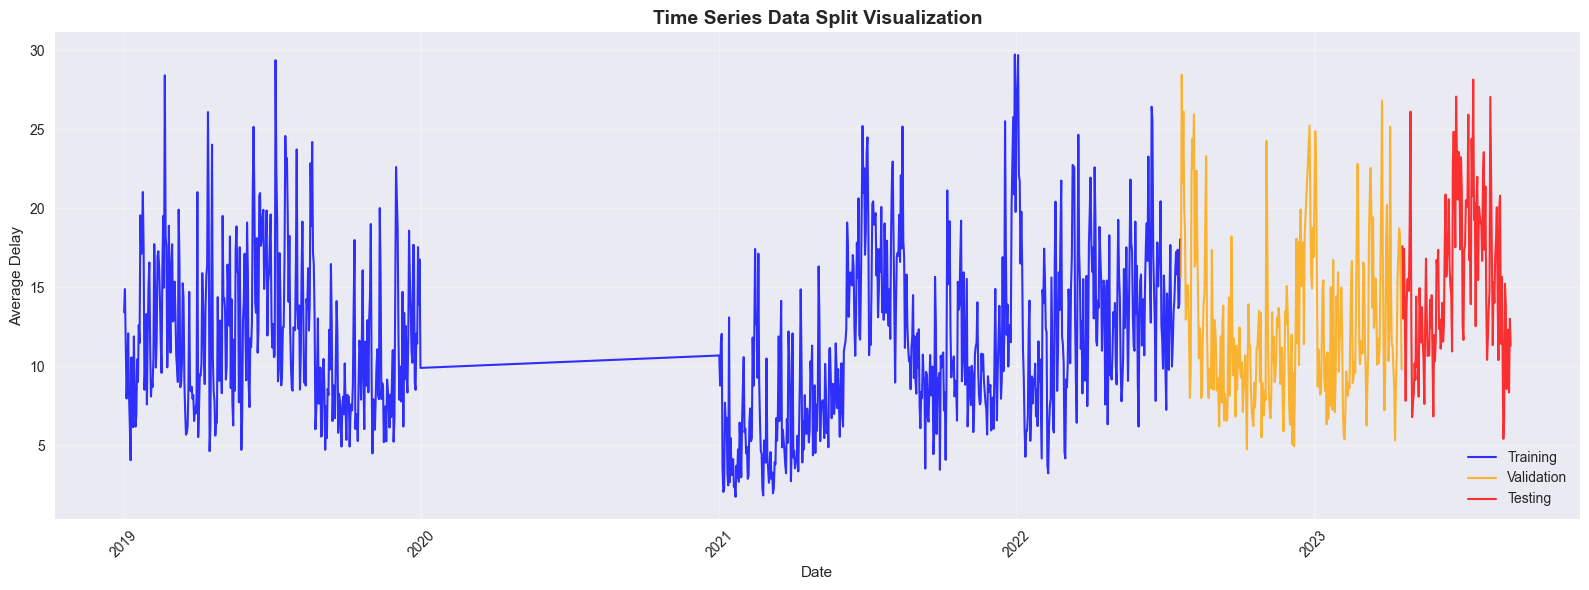

In [6]:
def smart_data_split(ts_data, train_ratio=0.7, val_ratio=0.2):
    """Smart chronological data splitting with validation"""
    
    n = len(ts_data)
    train_size = int(n * train_ratio)
    val_size = int(n * val_ratio)
    
    train_data = ts_data[:train_size].copy()
    val_data = ts_data[train_size:train_size + val_size].copy()
    test_data = ts_data[train_size + val_size:].copy()
    
    print("✂️ SMART DATA SPLITTING:")
    print(f"📚 Training: {len(train_data)} days ({train_data['ds'].min().date()} to {train_data['ds'].max().date()})")
    print(f"🔍 Validation: {len(val_data)} days ({val_data['ds'].min().date()} to {val_data['ds'].max().date()})")
    print(f"🧪 Testing: {len(test_data)} days ({test_data['ds'].min().date()} to {test_data['ds'].max().date()})")
    
    # Check for data leakage and temporal consistency
    assert train_data['ds'].max() < val_data['ds'].min(), "❌ Data leakage detected in train/val split!"
    assert val_data['ds'].max() < test_data['ds'].min(), "❌ Data leakage detected in val/test split!"
    print("✅ No data leakage detected")
    
    # Visualize the split with better formatting
    plt.figure(figsize=(16, 6))
    plt.plot(train_data['ds'], train_data['y'], label='Training', color='blue', alpha=0.8, linewidth=1.5)
    plt.plot(val_data['ds'], val_data['y'], label='Validation', color='orange', alpha=0.8, linewidth=1.5)
    plt.plot(test_data['ds'], test_data['y'], label='Testing', color='red', alpha=0.8, linewidth=1.5)
    
    plt.title('Time Series Data Split Visualization', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Average Delay')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return train_data, val_data, test_data

# Execute smart data splitting
train_data, val_data, test_data = smart_data_split(ts_data)

🔮 TRAINING ADVANCED PROPHET MODEL
⚠️ Holidays library not available, skipping holiday effects

🏗️ Model configuration:
- Seasonality: Daily, Weekly, Yearly, Monthly, Quarterly
- External regressors: Weekend, Peak hours, Flight count, Volatility
- Changepoint detection: Enhanced with 25 changepoints
- Mode: Additive seasonality

⚙️ Training Prophet model...


17:59:39 - cmdstanpy - INFO - Chain [1] start processing
17:59:40 - cmdstanpy - INFO - Chain [1] done processing


✅ Advanced Prophet model training completed!

📊 Training Performance:
- Training MAE: 1.0546
- Training R²: 0.9310


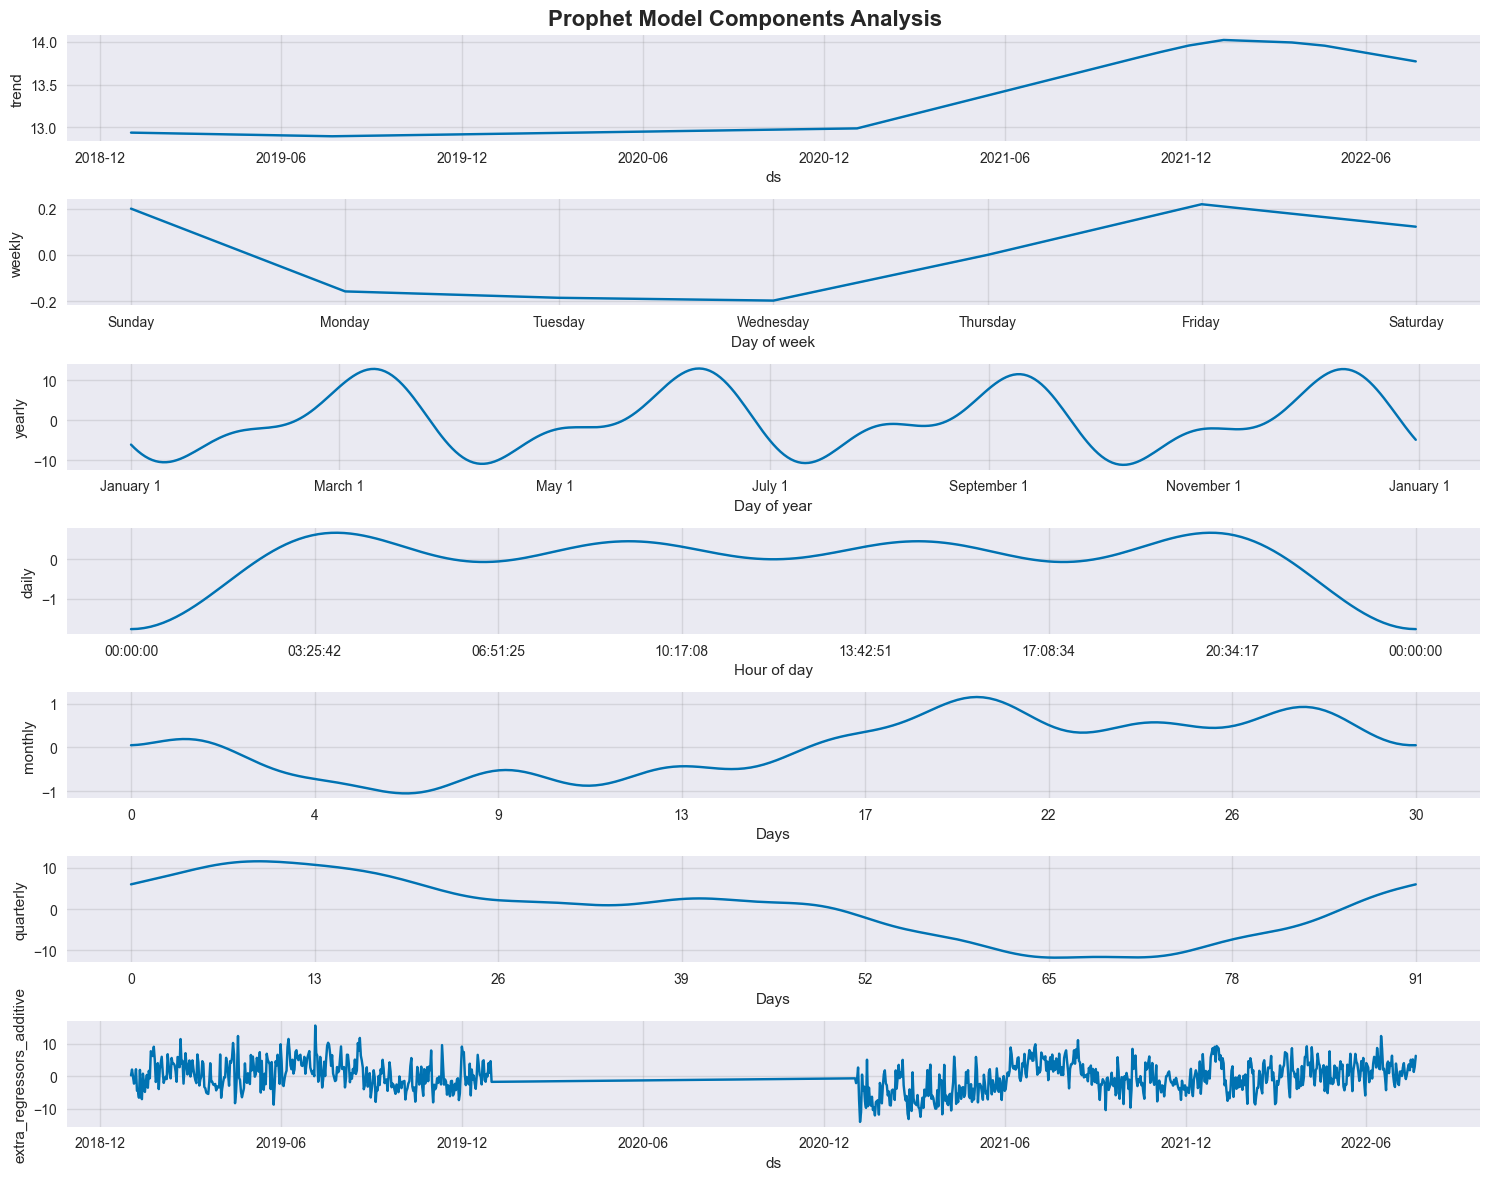

In [7]:
def train_advanced_prophet_model(train_data):
    """Train Prophet model with advanced configuration and external regressors"""
    
    print("🔮 TRAINING ADVANCED PROPHET MODEL")
    print("=" * 60)
    
    # Initialize Prophet with optimized parameters
    prophet_model = Prophet(
        # Core parameters
        growth='linear',                    # Try 'logistic' if there are capacity constraints
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        
        # Advanced parameters for better performance
        seasonality_mode='additive',        # Start with additive, can try multiplicative
        changepoint_prior_scale=0.1,        # Increased flexibility for trend changes
        seasonality_prior_scale=15,         # Increased flexibility for seasonality
        holidays_prior_scale=15,            # Flexibility for holidays
        
        # Uncertainty and fitting
        interval_width=0.95,
        mcmc_samples=0,                     # Use MAP estimation
        
        # Advanced options
        n_changepoints=25,                  # More changepoints for flexibility
        changepoint_range=0.9,              # Consider changepoints in 90% of history
    )
    
    # Add external regressors
    prophet_model.add_regressor('is_weekend', prior_scale=10)
    prophet_model.add_regressor('peak_hour_ratio', prior_scale=10)
    prophet_model.add_regressor('flight_count', prior_scale=5)
    prophet_model.add_regressor('delay_volatility', prior_scale=8)
    
    # Add custom seasonalities with different Fourier orders
    prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=8)
    prophet_model.add_seasonality(name='quarterly', period=91.25, fourier_order=10)
    
    # Add holidays (US holidays as example - adjust for your region)
    try:
        import holidays
        us_holidays = holidays.US()
        holiday_dates = []
        holiday_names = []
        
        for date in pd.date_range(start=train_data['ds'].min(), end=train_data['ds'].max()):
            if date.date() in us_holidays:
                holiday_dates.append(date)
                holiday_names.append(us_holidays[date.date()])
        
        if holiday_dates:
            holidays_df = pd.DataFrame({
                'holiday': holiday_names,
                'ds': holiday_dates,
            })
            prophet_model = Prophet(
                holidays=holidays_df,
                **{k: v for k, v in prophet_model.__dict__.items() 
                   if k not in ['holidays', 'train_holiday_names']}
            )
            print(f"✅ Added {len(holidays_df)} holidays to the model")
    except:
        print("⚠️ Holidays library not available, skipping holiday effects")
    
    print("\n🏗️ Model configuration:")
    print("- Seasonality: Daily, Weekly, Yearly, Monthly, Quarterly")
    print("- External regressors: Weekend, Peak hours, Flight count, Volatility")
    print("- Changepoint detection: Enhanced with 25 changepoints")
    print("- Mode: Additive seasonality")
    
    # Fit the model
    print("\n⚙️ Training Prophet model...")
    prophet_model.fit(train_data)
    print("✅ Advanced Prophet model training completed!")
    
    # Model diagnostics - in-sample fit
    train_forecast = prophet_model.predict(train_data)
    train_mae = mean_absolute_error(train_data['y'], train_forecast['yhat'])
    train_r2 = r2_score(train_data['y'], train_forecast['yhat'])
    
    print(f"\n📊 Training Performance:")
    print(f"- Training MAE: {train_mae:.4f}")
    print(f"- Training R²: {train_r2:.4f}")
    
    # Plot components
    fig = prophet_model.plot_components(train_forecast, figsize=(15, 12))
    plt.suptitle('Prophet Model Components Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return prophet_model

# Execute advanced Prophet training
prophet_model = train_advanced_prophet_model(train_data)



📈 TRAINING OPTIMIZED SARIMA MODEL
📊 Residuals analysis:
- Mean: 0.000074
- Std: 1.3506
- Skewness: 0.4850
- Kurtosis: 1.4670


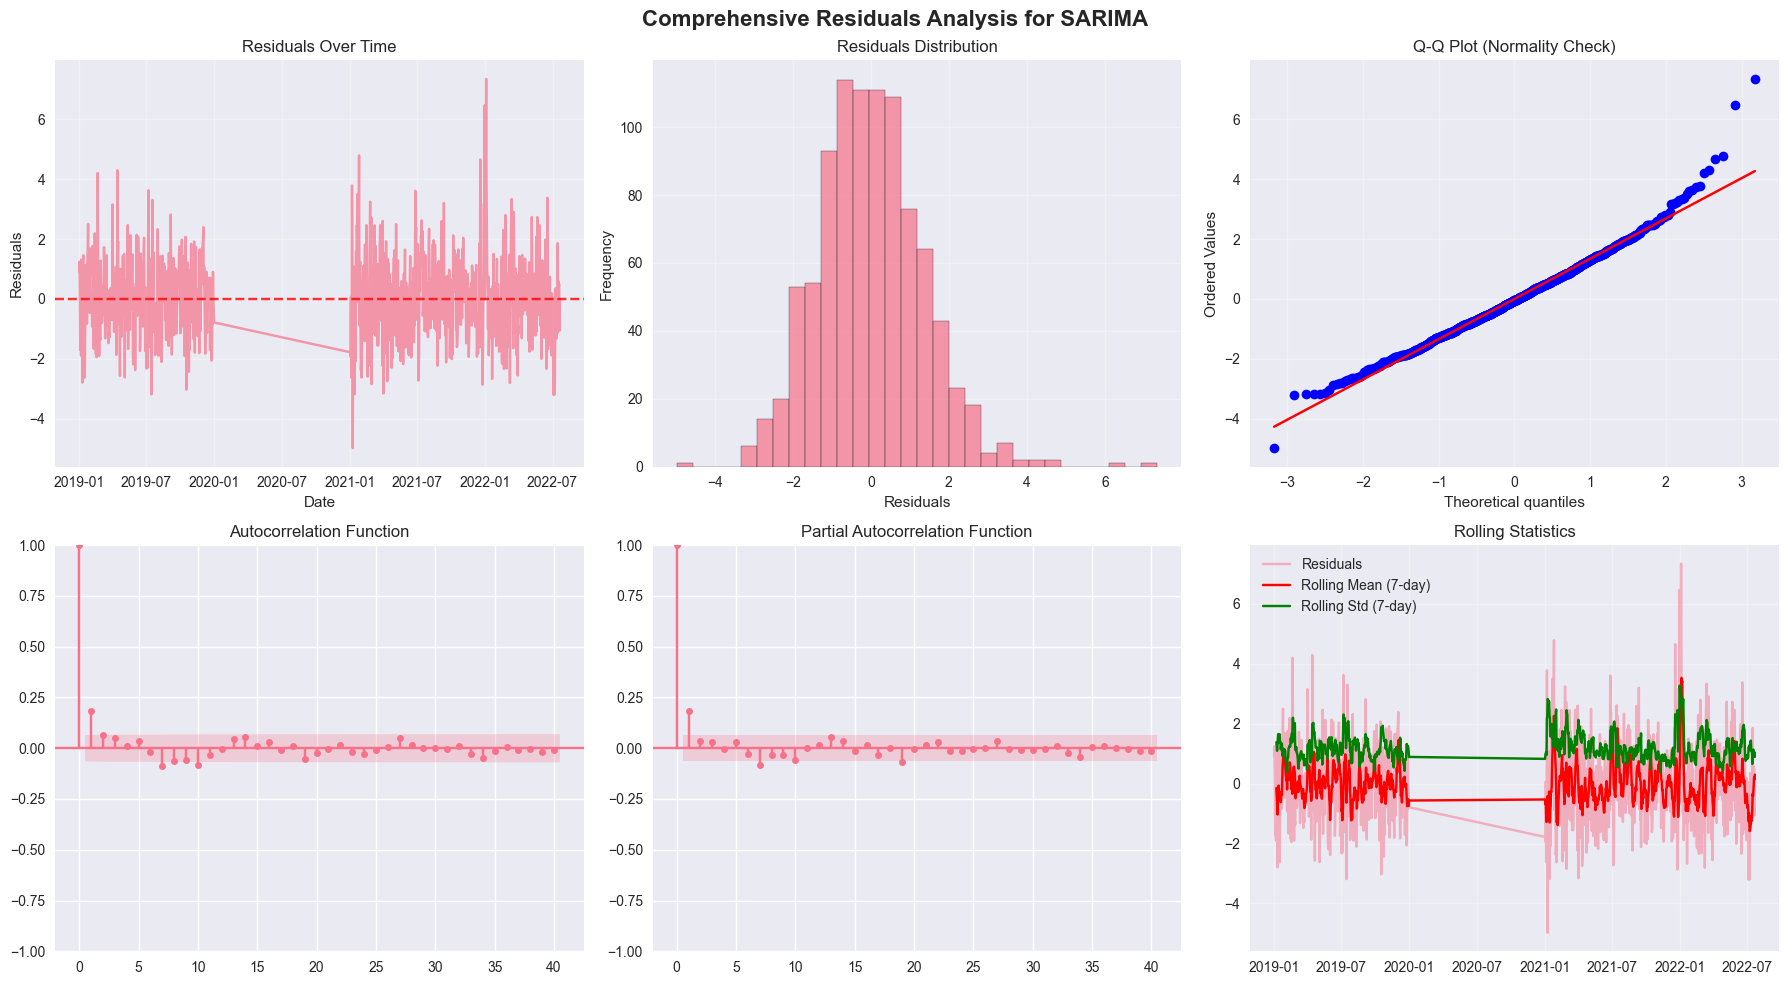


🔍 Residuals stationarity test:
- ADF Statistic: -25.301596
- p-value: 0.000000
- Stationary: Yes

🔍 Advanced SARIMA parameter optimization...
Testing 864 SARIMA configurations...


C:\Users\DELL\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\AppData\Roamin

✅ Tested 864/864 models successfully

⚙️ Training final SARIMA model with optimized parameters...
✅ Final SARIMA model trained successfully!

📊 SARIMA model diagnostics:


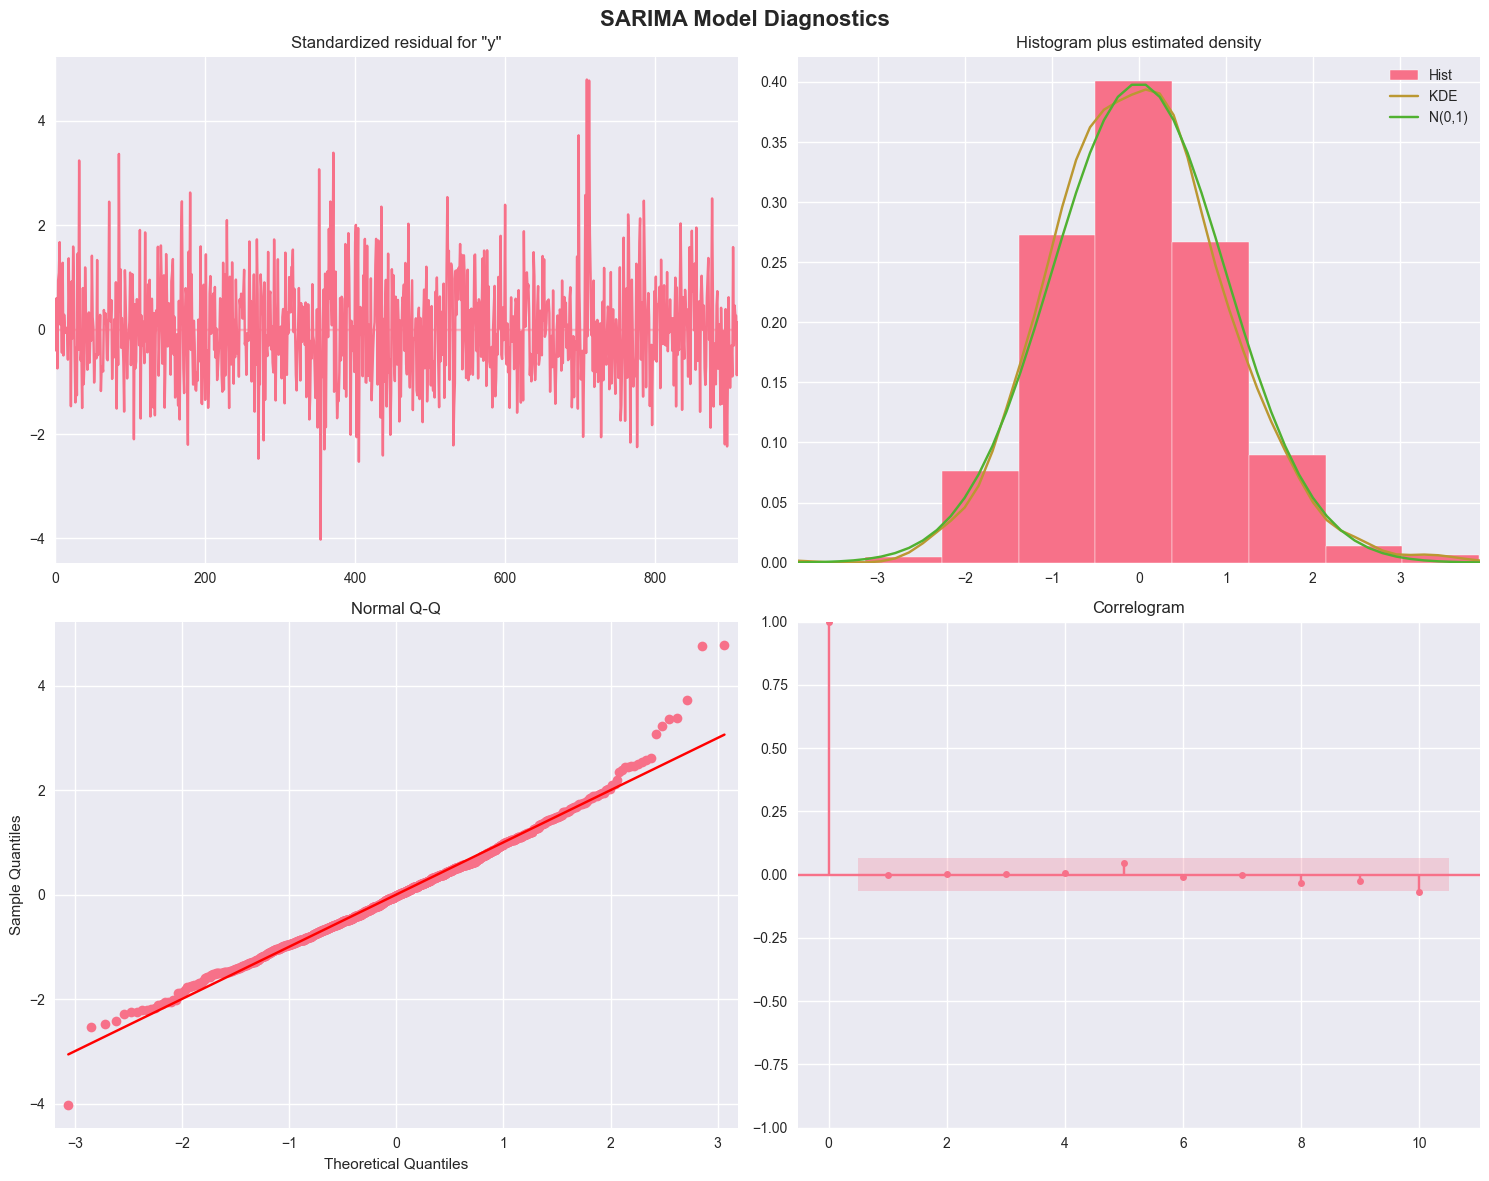

In [8]:
def train_optimized_sarima_model(prophet_model, train_data):
    """Train optimized SARIMA model on Prophet residuals"""
    
    print("\n📈 TRAINING OPTIMIZED SARIMA MODEL")
    print("=" * 60)
    
    # Get Prophet predictions on training data
    prophet_train_pred = prophet_model.predict(train_data)
    residuals = train_data['y'].values - prophet_train_pred['yhat'].values
    
    print(f"📊 Residuals analysis:")
    print(f"- Mean: {np.mean(residuals):.6f}")
    print(f"- Std: {np.std(residuals):.4f}")
    print(f"- Skewness: {stats.skew(residuals):.4f}")
    print(f"- Kurtosis: {stats.kurtosis(residuals):.4f}")
    
    # Comprehensive residuals analysis
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Comprehensive Residuals Analysis for SARIMA', fontsize=16, fontweight='bold')
    
    # Residuals over time
    axes[0, 0].plot(train_data['ds'], residuals, alpha=0.7)
    axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.8)
    axes[0, 0].set_title('Residuals Over Time')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Residuals distribution
    axes[0, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Residuals Distribution')
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Q-Q plot
    stats.probplot(residuals, dist="norm", plot=axes[0, 2])
    axes[0, 2].set_title('Q-Q Plot (Normality Check)')
    axes[0, 2].grid(True, alpha=0.3)
    
    # ACF plot
    plot_acf(residuals, lags=40, ax=axes[1, 0], alpha=0.05)
    axes[1, 0].set_title('Autocorrelation Function')
    
    # PACF plot
    plot_pacf(residuals, lags=40, ax=axes[1, 1], alpha=0.05)
    axes[1, 1].set_title('Partial Autocorrelation Function')
    
    # Rolling statistics
    rolling_mean = pd.Series(residuals).rolling(window=7).mean()
    rolling_std = pd.Series(residuals).rolling(window=7).std()
    
    axes[1, 2].plot(train_data['ds'], residuals, label='Residuals', alpha=0.5)
    axes[1, 2].plot(train_data['ds'], rolling_mean, label='Rolling Mean (7-day)', color='red')
    axes[1, 2].plot(train_data['ds'], rolling_std, label='Rolling Std (7-day)', color='green')
    axes[1, 2].set_title('Rolling Statistics')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Stationarity test
    adf_result = adfuller(residuals)
    print(f"\n🔍 Residuals stationarity test:")
    print(f"- ADF Statistic: {adf_result[0]:.6f}")
    print(f"- p-value: {adf_result[1]:.6f}")
    print(f"- Stationary: {'Yes' if adf_result[1] <= 0.05 else 'No'}")
    
    # Enhanced SARIMA parameter optimization
    try:
        print("\n🔍 Advanced SARIMA parameter optimization...")
        
        best_aic = float('inf')
        best_bic = float('inf')
        best_order = None
        best_seasonal_order = None
        
        # Expanded parameter search space
        p_values = range(0, 4)  # Expanded range
        d_values = range(0, 3)  # Include d=2
        q_values = range(0, 4)  # Expanded range
        
        P_values = range(0, 3)  # Seasonal AR
        D_values = range(0, 2)  # Seasonal differencing
        Q_values = range(0, 3)  # Seasonal MA
        s_value = 7             # Weekly seasonality
        
        models_tested = 0
        total_models = len(p_values) * len(d_values) * len(q_values) * len(P_values) * len(D_values) * len(Q_values)
        
        print(f"Testing {total_models} SARIMA configurations...")
        
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    for P in P_values:
                        for D in D_values:
                            for Q in Q_values:
                                try:
                                    model = SARIMAX(residuals,
                                                   order=(p, d, q),
                                                   seasonal_order=(P, D, Q, s_value),
                                                   enforce_stationarity=False,
                                                   enforce_invertibility=False,
                                                   simple_differencing=False)
                                    
                                    fitted_model = model.fit(disp=False, maxiter=100)
                                    
                                    # Consider both AIC and BIC
                                    if fitted_model.aic < best_aic:
                                        best_aic = fitted_model.aic
                                        best_bic = fitted_model.bic
                                        best_order = (p, d, q)
                                        best_seasonal_order = (P, D, Q, s_value)
                                    
                                    models_tested += 1
                                    
                                except:
                                    continue
        
        print(f"✅ Tested {models_tested}/{total_models} models successfully")
        
        if best_order is not None:
            print("\n⚙️ Training final SARIMA model with optimized parameters...")
            final_sarima = SARIMAX(residuals,
                                 order=best_order,
                                 seasonal_order=best_seasonal_order,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
            
            final_sarima_fit = final_sarima.fit(disp=False, maxiter=200)
            print("✅ Final SARIMA model trained successfully!")
            
            # Plot diagnostics
            print("\n📊 SARIMA model diagnostics:")
            final_sarima_fit.plot_diagnostics(figsize=(15, 12))
            plt.suptitle('SARIMA Model Diagnostics', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            return final_sarima_fit, best_order, best_seasonal_order
    
    except Exception as e:
        print(f"❌ Error during SARIMA optimization: {str(e)}")
        return None, None, None
    
    return None, None, None

# Execute SARIMA training
sarima_model, best_order, best_seasonal_order = train_optimized_sarima_model(prophet_model, train_data)


🧪 MODEL EVALUATION

📊 VALIDATION SET PERFORMANCE:
- Hybrid Model MAE: 1.1875
- Hybrid Model RMSE: 1.5265
- Hybrid Model R²: 0.8986
- Prophet-only MAE: 1.1852
- Prophet-only R²: 0.8990
📈 Improvement: -0.19% MAE reduction

🧪 TEST SET PERFORMANCE:
- Hybrid Model MAE: 1.3576
- Hybrid Model RMSE: 1.8005
- Hybrid Model R²: 0.8674
- Prophet-only MAE: 1.3536
- Prophet-only R²: 0.8682
📈 Improvement: -0.30% MAE reduction


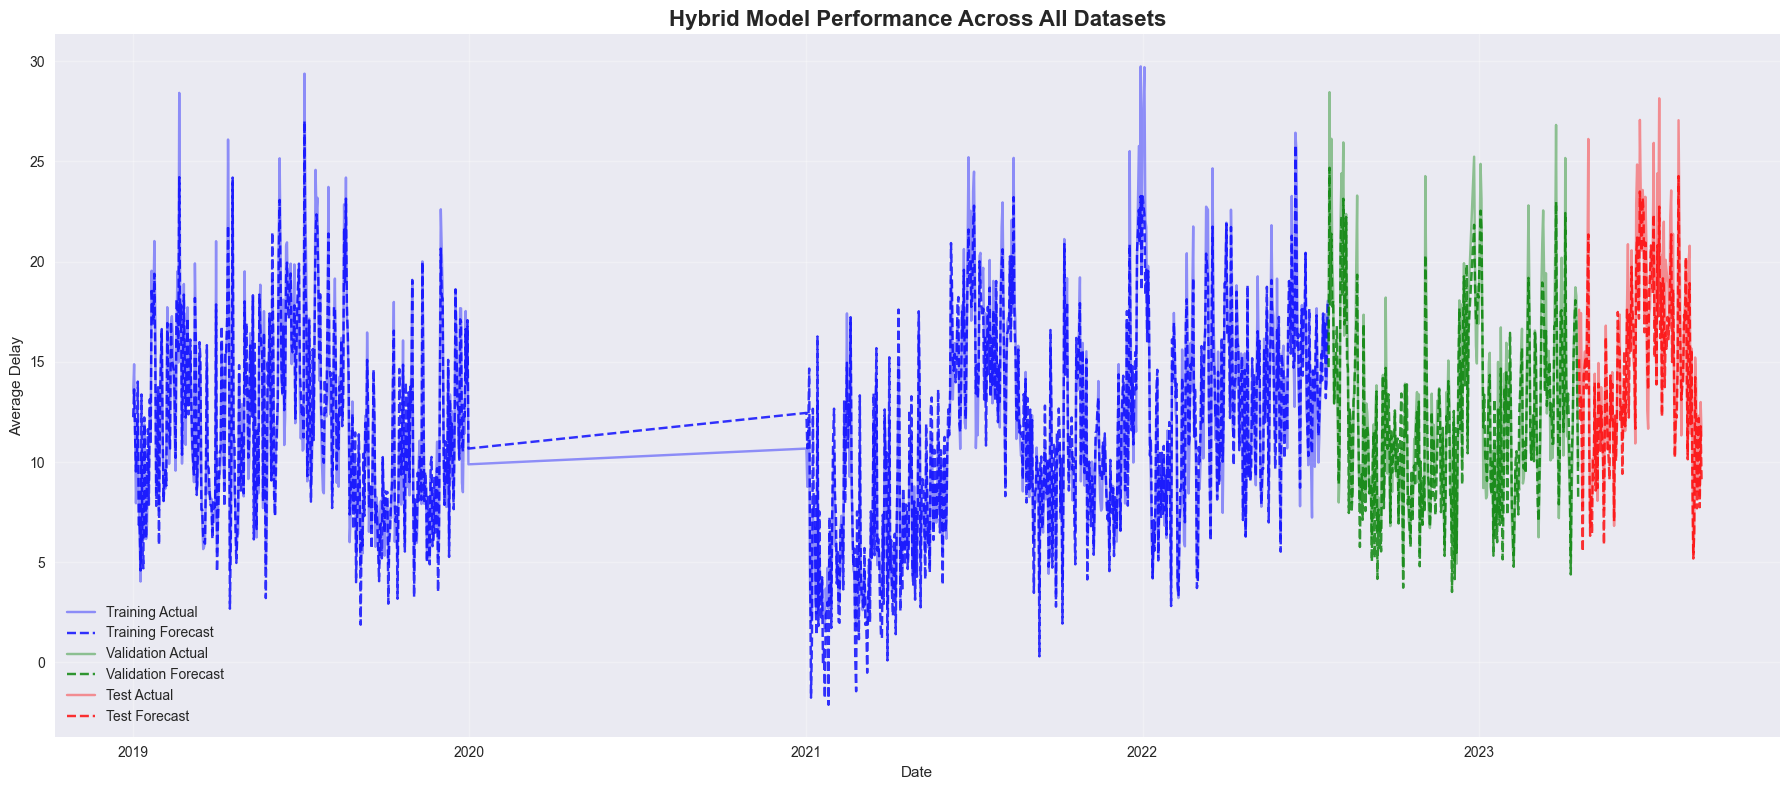

In [9]:


def hybrid_forecast(prophet_model, sarima_model, data, log_transformed=False):
    """Generate hybrid Prophet-SARIMA forecasts"""
    
    # Get Prophet forecast
    prophet_forecast = prophet_model.predict(data)
    
    # Get SARIMA forecast for residuals
    forecast_steps = len(data)
    sarima_forecast = sarima_model.get_forecast(steps=forecast_steps)
    sarima_pred = sarima_forecast.predicted_mean
    
    # Combine forecasts
    combined_forecast = prophet_forecast['yhat'].values + sarima_pred
    
    # Inverse log transform if needed
    if log_transformed:
        combined_forecast = np.expm1(combined_forecast)
        prophet_forecast['yhat'] = np.expm1(prophet_forecast['yhat'])
        data['y'] = np.expm1(data['y'])
    
    return combined_forecast, prophet_forecast

def evaluate_hybrid_model(prophet_model, sarima_model, train_data, val_data, test_data, log_transformed):
    """Comprehensive evaluation of the hybrid model"""
    
    print("\n🧪 MODEL EVALUATION")
    print("=" * 60)
    
    # Evaluate on validation set
    val_forecast, prophet_val_forecast = hybrid_forecast(prophet_model, sarima_model, val_data, log_transformed)
    
    val_mae = mean_absolute_error(val_data['y'], val_forecast)
    val_rmse = np.sqrt(mean_squared_error(val_data['y'], val_forecast))
    val_r2 = r2_score(val_data['y'], val_forecast)
    
    # Prophet-only metrics
    prophet_val_mae = mean_absolute_error(val_data['y'], prophet_val_forecast['yhat'])
    prophet_val_r2 = r2_score(val_data['y'], prophet_val_forecast['yhat'])
    
    print("\n📊 VALIDATION SET PERFORMANCE:")
    print(f"- Hybrid Model MAE: {val_mae:.4f}")
    print(f"- Hybrid Model RMSE: {val_rmse:.4f}")
    print(f"- Hybrid Model R²: {val_r2:.4f}")
    print(f"- Prophet-only MAE: {prophet_val_mae:.4f}")
    print(f"- Prophet-only R²: {prophet_val_r2:.4f}")
    print(f"📈 Improvement: {((prophet_val_mae - val_mae)/prophet_val_mae*100):.2f}% MAE reduction")
    
    # Evaluate on test set
    test_forecast, prophet_test_forecast = hybrid_forecast(prophet_model, sarima_model, test_data, log_transformed)
    
    test_mae = mean_absolute_error(test_data['y'], test_forecast)
    test_rmse = np.sqrt(mean_squared_error(test_data['y'], test_forecast))
    test_r2 = r2_score(test_data['y'], test_forecast)
    
    # Prophet-only metrics
    prophet_test_mae = mean_absolute_error(test_data['y'], prophet_test_forecast['yhat'])
    prophet_test_r2 = r2_score(test_data['y'], prophet_test_forecast['yhat'])
    
    print("\n🧪 TEST SET PERFORMANCE:")
    print(f"- Hybrid Model MAE: {test_mae:.4f}")
    print(f"- Hybrid Model RMSE: {test_rmse:.4f}")
    print(f"- Hybrid Model R²: {test_r2:.4f}")
    print(f"- Prophet-only MAE: {prophet_test_mae:.4f}")
    print(f"- Prophet-only R²: {prophet_test_r2:.4f}")
    print(f"📈 Improvement: {((prophet_test_mae - test_mae)/prophet_test_mae*100):.2f}% MAE reduction")
    
    # Plot forecasts vs actuals
    plt.figure(figsize=(18, 8))
    
    # Training set plot
    train_forecast, _ = hybrid_forecast(prophet_model, sarima_model, train_data, log_transformed)
    plt.plot(train_data['ds'], train_data['y'], label='Training Actual', color='blue', alpha=0.4)
    plt.plot(train_data['ds'], train_forecast, label='Training Forecast', color='blue', linestyle='--', alpha=0.8)
    
    # Validation set plot
    plt.plot(val_data['ds'], val_data['y'], label='Validation Actual', color='green', alpha=0.4)
    plt.plot(val_data['ds'], val_forecast, label='Validation Forecast', color='green', linestyle='--', alpha=0.8)
    
    # Test set plot
    plt.plot(test_data['ds'], test_data['y'], label='Test Actual', color='red', alpha=0.4)
    plt.plot(test_data['ds'], test_forecast, label='Test Forecast', color='red', linestyle='--', alpha=0.8)
    
    plt.title('Hybrid Model Performance Across All Datasets', fontsize=16, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Average Delay')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return {
        'validation': {'mae': val_mae, 'rmse': val_rmse, 'r2': val_r2},
        'test': {'mae': test_mae, 'rmse': test_rmse, 'r2': test_r2}
    }

# Evaluate the hybrid model
metrics = evaluate_hybrid_model(prophet_model, sarima_model, train_data, val_data, test_data, log_transformed)

In [10]:
def save_models(prophet_model, sarima_model, best_order, best_seasonal_order, log_transformed, model_dir='models'):
    """Save trained models and metadata"""
    
    print("\n💾 SAVING MODELS")
    print("=" * 60)
    
    # Create directory if it doesn't exist
    os.makedirs(model_dir, exist_ok=True)
    
    # Save Prophet model
    prophet_path = os.path.join(model_dir, 'prophet_model.pkl')
    with open(prophet_path, 'wb') as f:
        pickle.dump(prophet_model, f)
    
    # Save SARIMA model
    sarima_path = os.path.join(model_dir, 'sarima_model.pkl')
    with open(sarima_path, 'wb') as f:
        pickle.dump({
            'model': sarima_model,
            'order': best_order,
            'seasonal_order': best_seasonal_order
        }, f)
    
    # Save metadata
    metadata = {
        'log_transformed': log_transformed,
        'saved_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    metadata_path = os.path.join(model_dir, 'metadata.pkl')
    with open(metadata_path, 'wb') as f:
        pickle.dump(metadata, f)
    
    print(f"✅ Models saved to {model_dir} directory:")
    print(f"- Prophet model: {prophet_path}")
    print(f"- SARIMA model: {sarima_path}")
    print(f"- Metadata: {metadata_path}")

# Save the trained models
save_models(prophet_model, sarima_model, best_order, best_seasonal_order, log_transformed)




💾 SAVING MODELS
✅ Models saved to models directory:
- Prophet model: models\prophet_model.pkl
- SARIMA model: models\sarima_model.pkl
- Metadata: models\metadata.pkl



🔮 GENERATING FUTURE FORECASTS


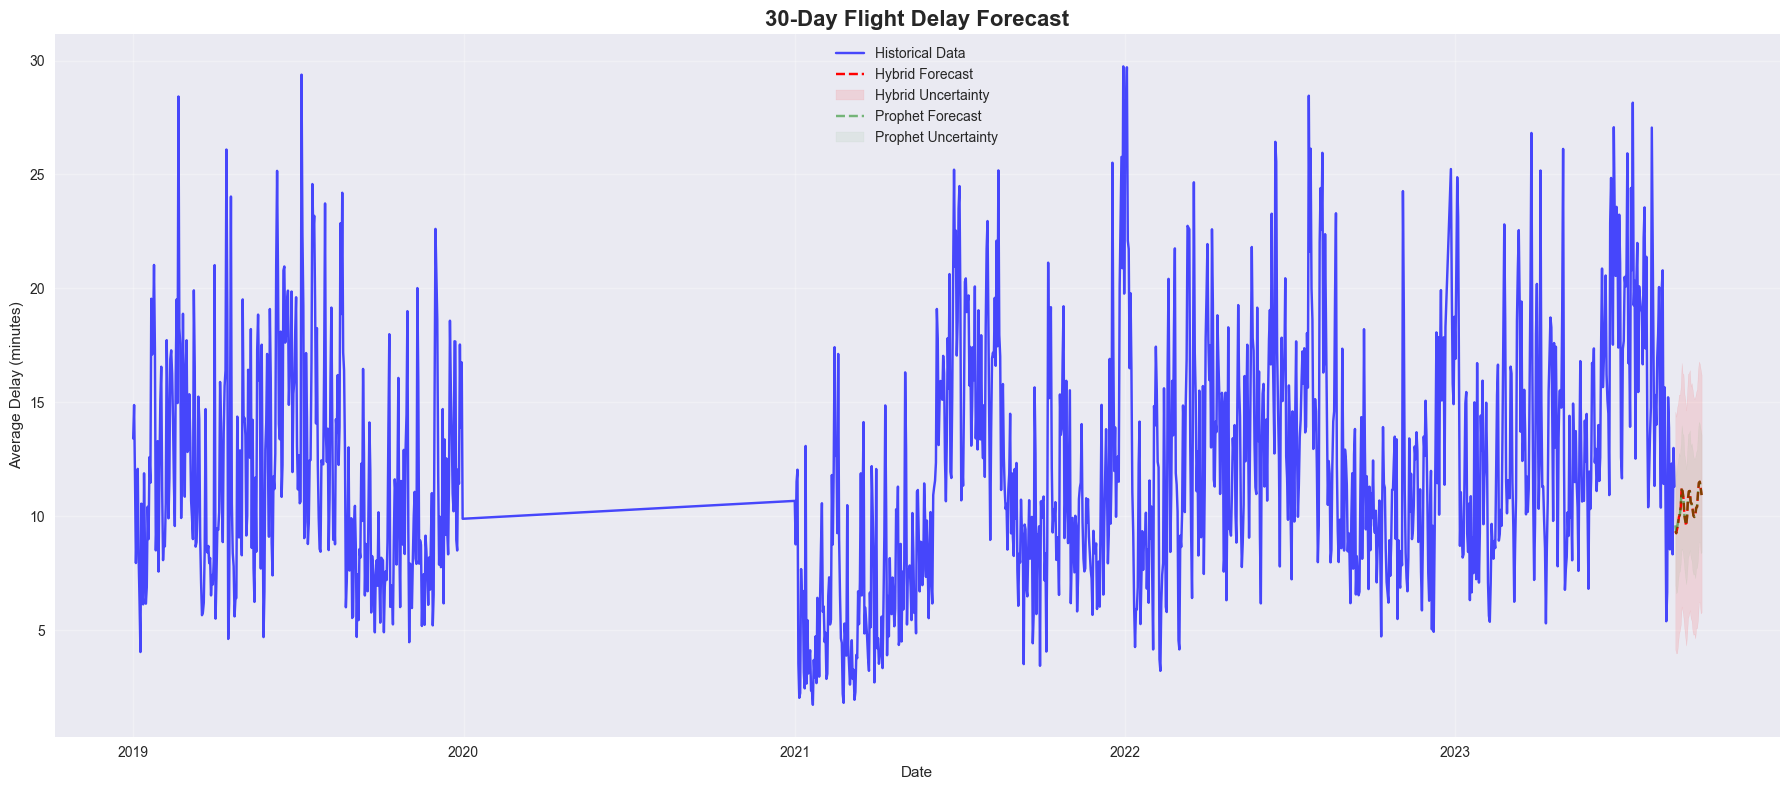


📅 FORECAST SUMMARY (next 5 days):
        ds  hybrid_yhat  hybrid_yhat_lower  hybrid_yhat_upper  prophet_yhat  prophet_yhat_lower  prophet_yhat_upper
2023-09-01     9.342543           4.140042          14.589354      9.597367            6.982243           12.256802
2023-09-02     9.248644           3.974234          14.371310      9.259973            6.610640           11.757562
2023-09-03     9.447363           3.989379          14.781241      9.515917            6.687647           12.220081
2023-09-04     9.636714           4.394392          14.945125      9.757145            7.147091           12.433289
2023-09-05     9.964706           4.829341          15.339301     10.043238            7.540141           12.785566


In [11]:
def generate_final_forecast(prophet_model, sarima_model, ts_data, days_to_forecast=30, log_transformed=False):
    """Generate future forecasts with uncertainty intervals"""
    
    print("\n🔮 GENERATING FUTURE FORECASTS")
    print("=" * 60)
    
    # Create future dataframe
    last_date = ts_data['ds'].max()
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days_to_forecast, freq='D')
    
    # Prepare future dataframe with regressors (using median values from training)
    future_df = pd.DataFrame({'ds': future_dates})
    
    # Add regressors (using median values from training)
    future_df['is_weekend'] = future_df['ds'].dt.dayofweek.isin([5, 6]).astype(int)
    future_df['peak_hour_ratio'] = train_data['peak_hour_ratio'].median()
    future_df['flight_count'] = train_data['flight_count'].median()
    future_df['delay_volatility'] = train_data['delay_volatility'].median()
    
    # Get Prophet forecast
    prophet_future = prophet_model.predict(future_df)
    
    # Get SARIMA forecast for residuals
    sarima_forecast = sarima_model.get_forecast(steps=days_to_forecast)
    sarima_pred = sarima_forecast.predicted_mean
    sarima_conf = sarima_forecast.conf_int()
    
    # Combine forecasts - FIXED: Use array indexing for sarima_conf
    combined_pred = prophet_future['yhat'].values + sarima_pred
    combined_lower = prophet_future['yhat_lower'].values + sarima_conf[:, 0]  # Changed from .iloc to array indexing
    combined_upper = prophet_future['yhat_upper'].values + sarima_conf[:, 1]   # Changed from .iloc to array indexing
    
    # Inverse log transform if needed
    if log_transformed:
        combined_pred = np.expm1(combined_pred)
        combined_lower = np.expm1(combined_lower)
        combined_upper = np.expm1(combined_upper)
        prophet_future['yhat'] = np.expm1(prophet_future['yhat'])
        prophet_future['yhat_lower'] = np.expm1(prophet_future['yhat_lower'])
        prophet_future['yhat_upper'] = np.expm1(prophet_future['yhat_upper'])
    
    # Create final forecast dataframe
    final_forecast = pd.DataFrame({
        'ds': future_dates,
        'hybrid_yhat': combined_pred,
        'hybrid_yhat_lower': combined_lower,
        'hybrid_yhat_upper': combined_upper,
        'prophet_yhat': prophet_future['yhat'].values,
        'prophet_yhat_lower': prophet_future['yhat_lower'].values,
        'prophet_yhat_upper': prophet_future['yhat_upper'].values
    })
    
    # Plot the forecast
    plt.figure(figsize=(18, 8))
    
    # Plot historical data
    plt.plot(ts_data['ds'], ts_data['y'], label='Historical Data', color='blue', alpha=0.7)
    
    # Plot hybrid forecast
    plt.plot(final_forecast['ds'], final_forecast['hybrid_yhat'], 
             label='Hybrid Forecast', color='red', linestyle='--')
    plt.fill_between(final_forecast['ds'], 
                    final_forecast['hybrid_yhat_lower'], 
                    final_forecast['hybrid_yhat_upper'],
                    color='red', alpha=0.1, label='Hybrid Uncertainty')
    
    # Plot Prophet-only forecast for comparison
    plt.plot(final_forecast['ds'], final_forecast['prophet_yhat'], 
             label='Prophet Forecast', color='green', linestyle='--', alpha=0.5)
    plt.fill_between(final_forecast['ds'], 
                    final_forecast['prophet_yhat_lower'], 
                    final_forecast['prophet_yhat_upper'],
                    color='green', alpha=0.05, label='Prophet Uncertainty')
    
    plt.title(f'{days_to_forecast}-Day Flight Delay Forecast', fontsize=16, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Average Delay (minutes)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print forecast summary
    print("\n📅 FORECAST SUMMARY (next 5 days):")
    print(final_forecast.head().to_string(index=False))
    
    return final_forecast

# Generate final forecasts
final_forecast = generate_final_forecast(prophet_model, sarima_model, ts_data, days_to_forecast=30, log_transformed=log_transformed)




🔮 GENERATING FORECASTS WITH ACTUAL VS PREDICTED ANALYSIS

📊 ACTUAL VS PREDICTED PERFORMANCE


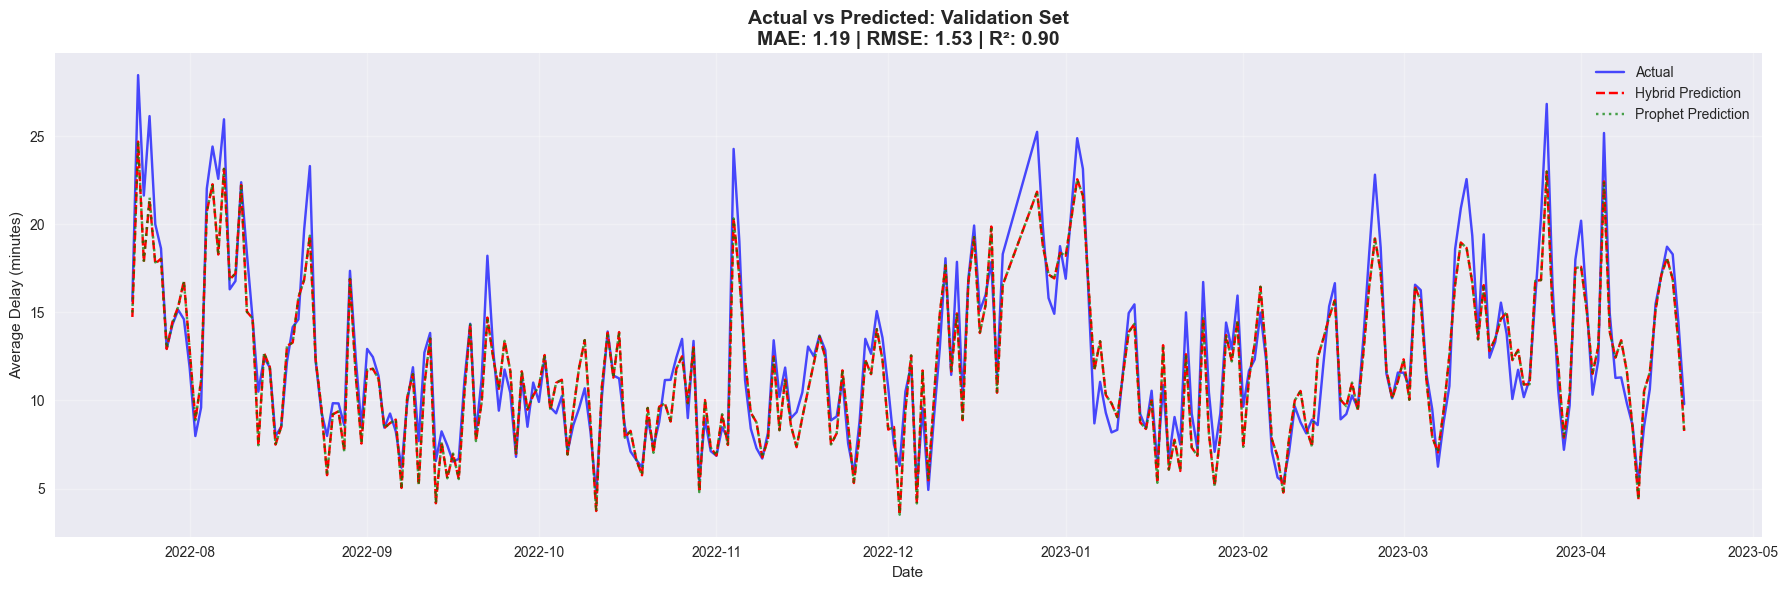

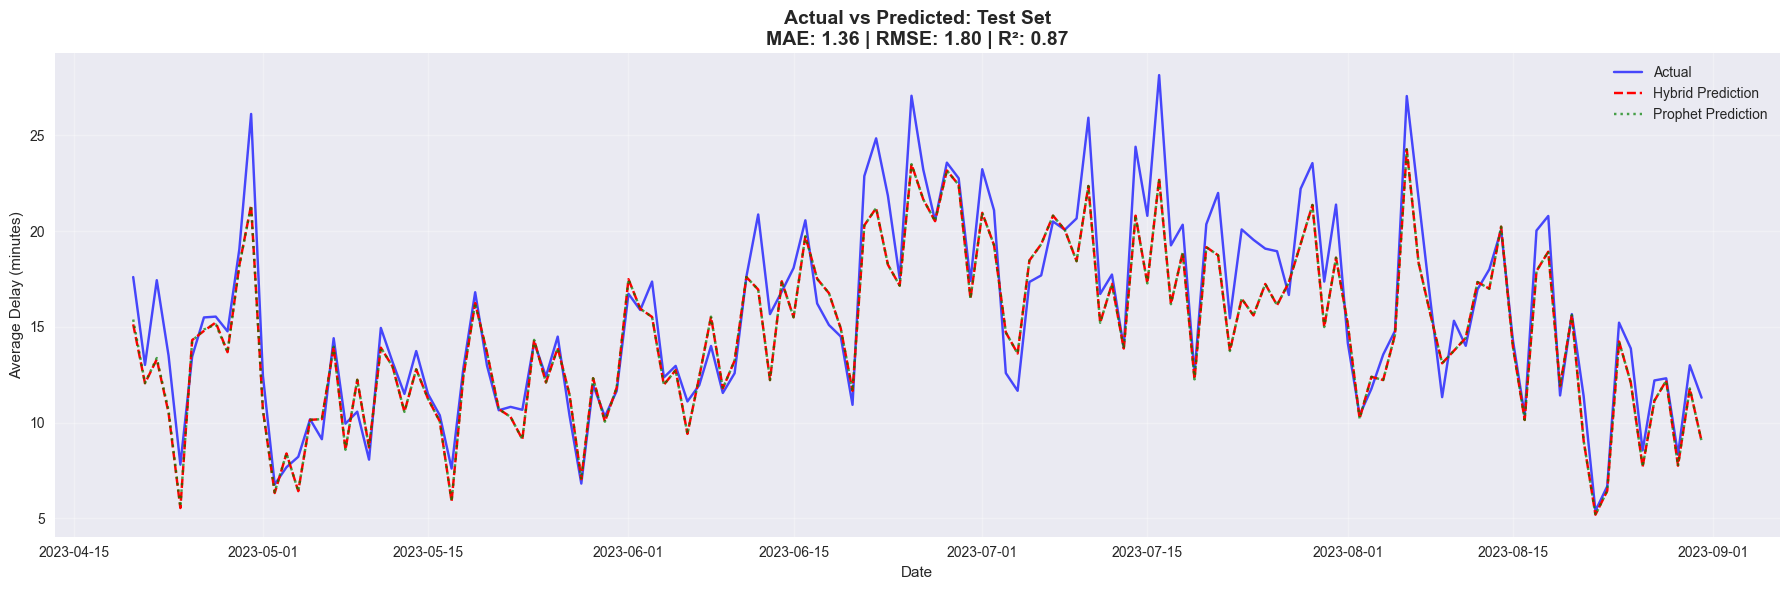


🔮 GENERATING FUTURE FORECASTS


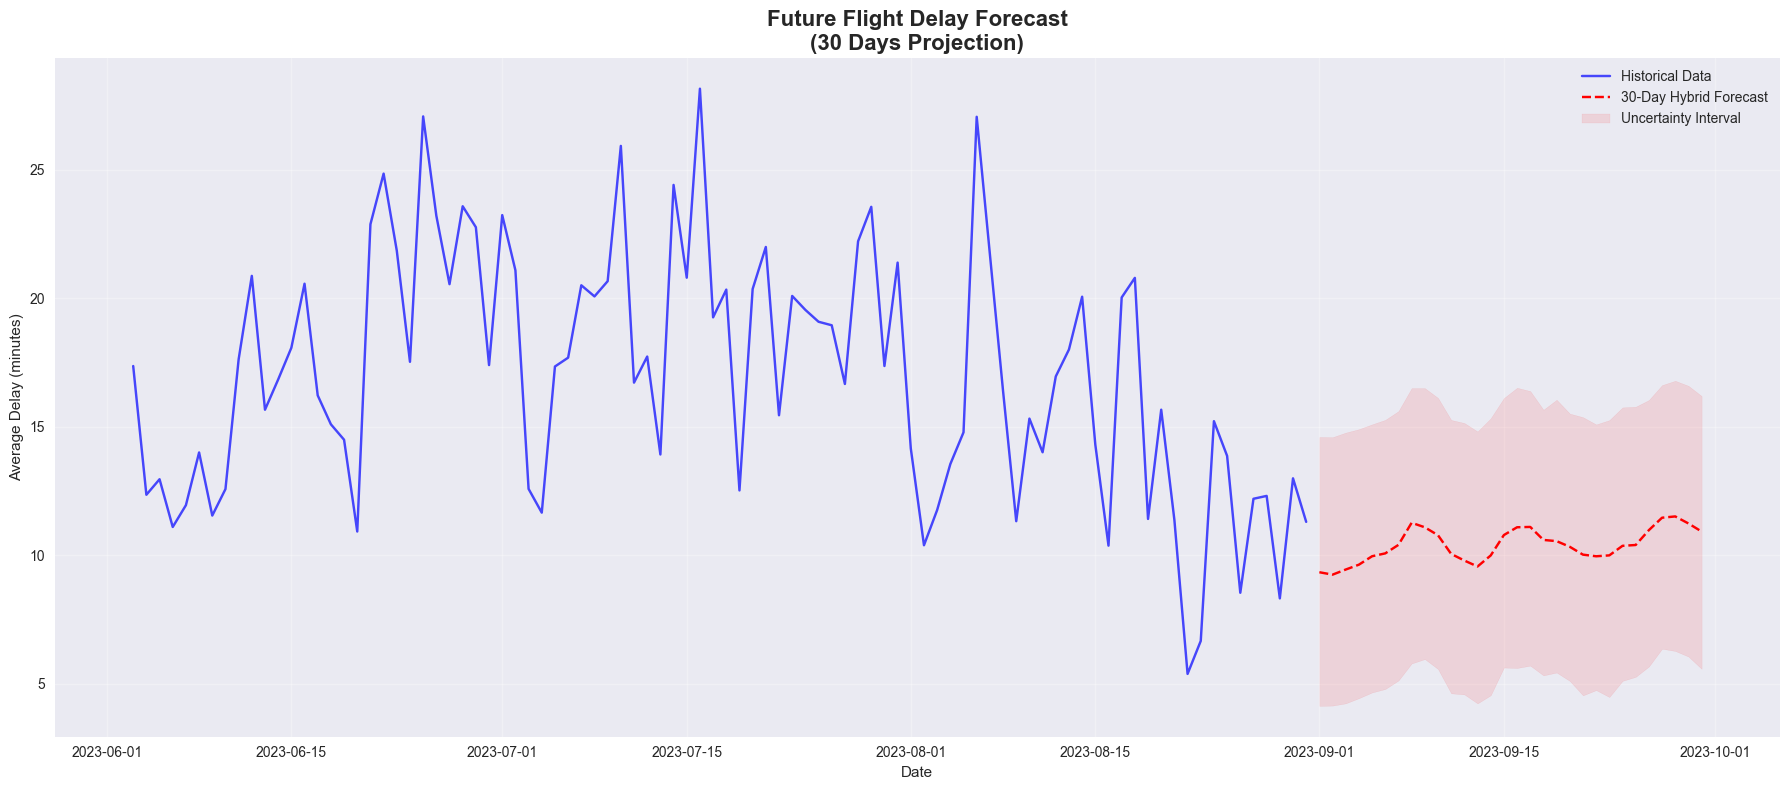


📅 FORECAST SUMMARY (Next 10 Days):
        ds  hybrid_yhat  hybrid_yhat_lower  hybrid_yhat_upper  prophet_yhat
2023-09-01         9.34               4.14              14.60          9.60
2023-09-02         9.25               4.16              14.59          9.26
2023-09-03         9.45               4.24              14.77          9.52
2023-09-04         9.64               4.44              14.91          9.76
2023-09-05         9.96               4.67              15.09         10.04
2023-09-06        10.08               4.80              15.27         10.03
2023-09-07        10.41               5.13              15.61         10.48
2023-09-08        11.27               5.80              16.50         11.17
2023-09-09        11.09               5.97              16.50         11.09
2023-09-10        10.78               5.58              16.12         10.75
2023-09-11        10.05               4.63              15.27         10.03
2023-09-12         9.80               4.59          

In [12]:
def generate_final_forecast(prophet_model, sarima_model, train_data, val_data, test_data, days_to_forecast=30, log_transformed=False):
    """Generate forecasts with actual vs prediction comparison and future projections"""
    
    print("\n🔮 GENERATING FORECASTS WITH ACTUAL VS PREDICTED ANALYSIS")
    print("=" * 70)
    
    # =====================================================================
    # 1. ACTUAL VS PREDICTED ANALYSIS (Validation/Test Sets)
    # =====================================================================
    def evaluate_predictions(data, dataset_name):
        """Helper function to evaluate and plot predictions"""
        # Get Prophet predictions
        prophet_pred = prophet_model.predict(data)
        
        # Get SARIMA predictions for residuals
        forecast_steps = len(data)
        sarima_pred = sarima_model.get_forecast(steps=forecast_steps).predicted_mean
        
        # Ensure lengths match
        if len(prophet_pred) != len(sarima_pred):
            min_length = min(len(prophet_pred), len(sarima_pred))
            prophet_pred = prophet_pred.iloc[:min_length]
            sarima_pred = sarima_pred[:min_length]
            data = data.iloc[:min_length]
        
        # Combine forecasts
        hybrid_pred = prophet_pred['yhat'].values + sarima_pred
        
        # Inverse transform if needed
        if log_transformed:
            hybrid_pred = np.expm1(hybrid_pred)
            prophet_pred['yhat'] = np.expm1(prophet_pred['yhat'])
            actuals = np.expm1(data['y'].values)
        else:
            actuals = data['y'].values
        
        # Calculate metrics
        mae = mean_absolute_error(actuals, hybrid_pred)
        rmse = np.sqrt(mean_squared_error(actuals, hybrid_pred))
        r2 = r2_score(actuals, hybrid_pred)
        
        # Create comparison dataframe
        comparison = pd.DataFrame({
            'ds': data['ds'],
            'actual': actuals,
            'hybrid_pred': hybrid_pred,
            'prophet_pred': prophet_pred['yhat'].values
        })
        
        # Plot results
        plt.figure(figsize=(18, 6))
        plt.plot(comparison['ds'], comparison['actual'], label='Actual', color='blue', alpha=0.7)
        plt.plot(comparison['ds'], comparison['hybrid_pred'], 
                label='Hybrid Prediction', color='red', linestyle='--')
        plt.plot(comparison['ds'], comparison['prophet_pred'], 
                label='Prophet Prediction', color='green', linestyle=':', alpha=0.7)
        
        plt.title(f'Actual vs Predicted: {dataset_name} Set\n'
                 f'MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.2f}', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('Average Delay (minutes)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return comparison
    
    print("\n📊 ACTUAL VS PREDICTED PERFORMANCE")
    val_comparison = evaluate_predictions(val_data, "Validation")
    test_comparison = evaluate_predictions(test_data, "Test")
    
    # =====================================================================
    # 2. FUTURE FORECAST GENERATION
    # =====================================================================
    print("\n🔮 GENERATING FUTURE FORECASTS")
    
    # Create future dataframe
    last_date = test_data['ds'].max()
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days_to_forecast, freq='D')
    future_df = pd.DataFrame({'ds': future_dates})
    
    # Add regressors (using median values from training)
    future_df['is_weekend'] = future_df['ds'].dt.dayofweek.isin([5, 6]).astype(int)
    future_df['peak_hour_ratio'] = train_data['peak_hour_ratio'].median()
    future_df['flight_count'] = train_data['flight_count'].median()
    future_df['delay_volatility'] = train_data['delay_volatility'].median()
    
    # Generate forecasts
    prophet_future = prophet_model.predict(future_df)
    sarima_forecast = sarima_model.get_forecast(steps=days_to_forecast)
    
    # Combine forecasts
    combined_pred = prophet_future['yhat'].values + sarima_forecast.predicted_mean
    combined_lower = prophet_future['yhat_lower'].values + sarima_forecast.conf_int()[:, 0]
    combined_upper = prophet_future['yhat_upper'].values + sarima_forecast.conf_int()[:, 1]
    
    # Inverse log transform if needed
    if log_transformed:
        combined_pred = np.expm1(combined_pred)
        combined_lower = np.expm1(combined_lower)
        combined_upper = np.expm1(combined_upper)
        prophet_future['yhat'] = np.expm1(prophet_future['yhat'])
    
    # Create forecast dataframe
    final_forecast = pd.DataFrame({
        'ds': future_dates,
        'hybrid_yhat': combined_pred,
        'hybrid_yhat_lower': combined_lower,
        'hybrid_yhat_upper': combined_upper,
        'prophet_yhat': prophet_future['yhat'].values
    })
    
    # Plot future forecast
    plt.figure(figsize=(18, 8))
    
    # Plot historical data (last 90 days for context)
    historical = pd.concat([train_data, val_data, test_data]).tail(90)
    plt.plot(historical['ds'], historical['y'], label='Historical Data', color='blue', alpha=0.7)
    
    # Plot hybrid forecast
    plt.plot(final_forecast['ds'], final_forecast['hybrid_yhat'], 
            label=f'{days_to_forecast}-Day Hybrid Forecast', color='red', linestyle='--')
    plt.fill_between(final_forecast['ds'], 
                    final_forecast['hybrid_yhat_lower'],
                    final_forecast['hybrid_yhat_upper'],
                    color='red', alpha=0.1, label='Uncertainty Interval')
    
    plt.title(f'Future Flight Delay Forecast\n({days_to_forecast} Days Projection)', 
             fontsize=16, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Average Delay (minutes)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print forecast summary
    print("\n📅 FORECAST SUMMARY (Next 10 Days):")
    print(final_forecast.head(30).round(2).to_string(index=False))
    
    return {
        'validation_comparison': val_comparison,
        'test_comparison': test_comparison,
        'future_forecast': final_forecast
    }

# Generate complete forecasts
forecast_results = generate_final_forecast(
    prophet_model, 
    sarima_model, 
    train_data, 
    val_data, 
    test_data,
    days_to_forecast=30,
    log_transformed=log_transformed
)

print("\n🎉 FORECASTING PIPELINE COMPLETED SUCCESSFULLY!")